# Lab Three: Clustering, Association Rules, Recommenders
### Laura Ahumada, Kevin Boyd, Shikha Pandey, Duy Nguyen
##### Southern Methodist University
##### Fall, 2022

# Business Understanding
* Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

#####

# Data Understanding Part 1
* Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

This dataset (ml-25m) describes 5-star rating activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 25,000,095 ratings across 62,423 movies; 59,047 of which are actually rated. These data were created by 162,541 users between January 09, 1995 and November 21, 2019. This dataset was generated on November 21, 2019.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

#####

In [1]:
#Importing Libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Reading the files
df_movies = pd.read_csv('movies.csv')
df_ratings = pd.read_csv('ratings.csv')

#Merging the Dataset
df_merge1=df_movies.merge(df_ratings,on="movieId")

In [3]:
print("Total number of ratings: ", df_merge1.shape[0])
print("Total number of unique users =", len(df_ratings.userId.unique()))
print("Total number of unique movies: ", len(df_movies.movieId.unique()))
#print("This last one is showing the unique movies in the df_rating file same info as the 3 sentence")
#-->print("Total number of unique rated movies =", len(df_ratings.movieId.unique()))

Total number of ratings:  100836
Total number of unique users = 610
Total number of unique movies:  9742


### Modifying the data to fit out business  case 

In [4]:
#Modify df to get info on rating saving it on its own column for our business case
updated=df_merge1.groupby("movieId").agg({"rating":("count",np.mean, np.median, np.std), "title":['first'],"genres":['first']})
updated=updated.reset_index()
#Fix columns names
updated.columns=["MovieId","TotalRatings","RatingMean","RatingMedian","RatingStd","Title","Genres"]

In [5]:
#Removing Year from the title and creating a year column
import re
updated['Year']=updated['Title'].str.findall(r'([-+]?\d*\.\d+|\d+)').str[-1]
updated['Title']=updated["Title"].replace('[0-9,()]+','',regex=True)

In [6]:
# Now let's update Genres by setting a column for each and removing the current Genres column

#all genres
genres_list=set([x  for y in updated['Genres'] for x in y.split("|")])

#Create Column for each of the Genres
for i in genres_list:
    updated[i]=["Yes" if i in x.split("|") else "No" for x in updated["Genres"]]
    
#droping Genres column
updated=updated.drop("Genres",axis=1)


In [86]:
genres_list

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [7]:
#We now have the final dataset that we can now do the EDA on
updated.head()

,MovieId,TotalRatings,RatingMean,RatingMedian,RatingStd,Title,Year,Crime,Western,Action,...,Thriller,Adventure,IMAX,Film-Noir,Documentary,Horror,War,Drama,Romance,Sci-Fi
0,1,215,3.920930,4.0,0.834859,Toy Story,1995,No,No,No,...,No,Yes,No,No,No,No,No,No,No,No
1,2,110,3.431818,3.5,0.881713,Jumanji,1995,No,No,No,...,No,Yes,No,No,No,No,No,No,No,No
2,3,52,3.259615,3.0,1.054823,Grumpier Old Men,1995,No,No,No,...,No,No,No,No,No,No,No,No,Yes,No
3,4,7,2.357143,3.0,0.852168,Waiting to Exhale,1995,No,No,No,...,No,No,No,No,No,No,No,Yes,Yes,No
4,5,49,3.071429,3.0,0.907148,Father of the Bride Part II,1995,No,No,No,...,No,No,No,No,No,No,No,No,No,No


## EDA

In [8]:
#323 movies don't have year
#(set(updated[updated["Year"].apply(lambda x: len(str(x)) < 4)]["Title"]))

### Missing Values
+ There are no missing values

In [9]:
updated.isnull().sum()

MovieId                  0
TotalRatings             0
RatingMean               0
RatingMedian             0
RatingStd             3446
Title                    0
Year                    10
Crime                    0
Western                  0
Action                   0
Children                 0
Comedy                   0
Mystery                  0
Musical                  0
Fantasy                  0
Animation                0
(no genres listed)       0
Thriller                 0
Adventure                0
IMAX                     0
Film-Noir                0
Documentary              0
Horror                   0
War                      0
Drama                    0
Romance                  0
Sci-Fi                   0
dtype: int64

***!! ARE YOU ALL OK TO REPLACE THESE NA OF STD WITH 0 SINCE THAT IS DUE TO THEM ONLY HAVING 1 RATING?***

In [10]:
#We can see that the Ratings with NA's are due to the movie only have 1 rating
#therefor these will be replaced with 0
updated[updated["RatingStd"].isnull()]["TotalRatings"].unique()

#updating value
updated['RatingStd'].fillna(0,inplace=True)

In [11]:
#Saving the title of movies without year
MoviesNoYear=updated[updated["Year"].isnull()]["MovieId"].tolist()

In [12]:
df_movies[df_movies["movieId"]==140956]["title"]

9031    Ready Player One
Name: title, dtype: object

In [13]:
#Using list of movies ID to retrieve original name from the original movie.df
# to verify that year is actually missing
for i in ((updated[updated["Year"].isnull()]["MovieId"])):
    print(df_movies[df_movies["movieId"]==i]["title"].to_string(index=False))

Ready Player One
Hyena Road
The Adventures of Sherlock Holmes and Doctor Wa...
Nocturnal Animals
Paterson
Moonlight
The OA
Cosmos
Maria Bamford: Old Baby
Black Mirror


Those series and movies don't have a year so we will:
+ Update year of movies that were found online 
+ Drop The Adventures of Sherlock Holmes and Doctor Watson which was had multiple movies and shows with different years

In [14]:
#Updating year for Moonlinght per online research
ind=updated.loc[(updated['Year'].isnull()) & (updated["Title"]=="Moonlight")].index[0]
updated.at[ind,'Year']=2016

#Updating year of Black Mirror per online research
ind=updated.loc[(updated['Year'].isnull()) & (updated["Title"]=="Black Mirror")].index[0]
updated.at[ind,'Year']=2011

#Updating year of Maria Bamford: Old Baby per online research
ind=updated.loc[(updated['Year'].isnull()) & (updated["Title"]=="Maria Bamford: Old Baby")].index[0]
updated.at[ind,'Year']=2017

#Updating year of Hyena Road per online research
ind=updated.loc[(updated['Year'].isnull()) & (updated["Title"]=="Hyena Road")].index[0]
updated.at[ind,'Year']=2015

#Updating year of Ready Player One per online research
ind=updated.loc[(updated['Year'].isnull()) & (updated["Title"]=="Ready Player One")].index[0]
updated.at[ind,'Year']=2018

#Updating year of Paterson per online research
ind=updated.loc[(updated['Year'].isnull()) & (updated["Title"]=="Paterson")].index[0]
updated.at[ind,'Year']=2016

#Updating year of The OA per online research
ind=updated.loc[(updated['Year'].isnull()) & (updated["Title"]=="The OA")].index[0]
updated.at[ind,'Year']=2016

#Updating year of Cosmos per online research
ind=updated.loc[(updated['Year'].isnull()) & (updated["Title"]=="Cosmos")].index[0]
updated.at[ind,'Year']=2019

#Updating year of Nocturnal Animals per online research
ind=updated.loc[(updated['Year'].isnull()) & (updated["Title"]=="Nocturnal Animals")].index[0]
updated.at[ind,'Year']=2016

#Dropping NA
updated.dropna(inplace=True)


In [15]:
#Checking that there are no missing values 
updated.isnull().sum()

MovieId               0
TotalRatings          0
RatingMean            0
RatingMedian          0
RatingStd             0
Title                 0
Year                  0
Crime                 0
Western               0
Action                0
Children              0
Comedy                0
Mystery               0
Musical               0
Fantasy               0
Animation             0
(no genres listed)    0
Thriller              0
Adventure             0
IMAX                  0
Film-Noir             0
Documentary           0
Horror                0
War                   0
Drama                 0
Romance               0
Sci-Fi                0
dtype: int64

### Duplicated Values
+ No duplicated values

### What shall we do with these movies? We have enough data, I think we should remove
--> ***WINCE WE ARE NOW USING THE SMALL DATA AND JOINED WITH INNER THERE ARE NO MOVIES WITH DUPLICATE NAMES :D*** 

In [16]:
updated[updated.duplicated(keep='first')].sum()

MovieId               0.0
TotalRatings          0.0
RatingMean            0.0
RatingMedian          0.0
RatingStd             0.0
Title                 0.0
Year                  0.0
Crime                 0.0
Western               0.0
Action                0.0
Children              0.0
Comedy                0.0
Mystery               0.0
Musical               0.0
Fantasy               0.0
Animation             0.0
(no genres listed)    0.0
Thriller              0.0
Adventure             0.0
IMAX                  0.0
Film-Noir             0.0
Documentary           0.0
Horror                0.0
War                   0.0
Drama                 0.0
Romance               0.0
Sci-Fi                0.0
dtype: float64

### There are some movies with the same name but we can see each has the rating and Category therefore we will keep them in the data since we are looking Genres

In [17]:
#There are some movies with same name
updated["Title"].value_counts()

                                 13
Hamlet                            5
 Up                               5
Christmas Carol A                 4
Three Musketeers The              4
                                 ..
All That Heaven Allows            1
Thing with Two Heads The          1
Something Wild                    1
Shadows and Fog                   1
Andrew Dice Clay: Dice Rules      1
Name: Title, Length: 9384, dtype: int64

In [18]:
#Let's see which movies
updated['Title'].value_counts()[updated['Title'].value_counts()> 1].to_string()

"                                                13\nHamlet                                           5\n Up                                              5\nChristmas Carol A                                4\nThree Musketeers The                             4\nJane Eyre                                        4\nMisérables Les                                   4\nKing Kong                                        3\nTaxi                                             3\nAlice in Wonderland                              3\nLittle Women                                     3\nEmma                                             3\nPeter Pan                                        3\nCinderella                                       3\nCarrie                                           3\nProject X                                        3\nScary Movie                                      3\nGulliver's Travels                               3\nHunchback of Notre Dame The                      3\nScream     

In [19]:
#Check an example
updated[updated["Title"]=="Dawn of the Dead "]

,MovieId,TotalRatings,RatingMean,RatingMedian,RatingStd,Title,Year,Crime,Western,Action,...,Thriller,Adventure,IMAX,Film-Noir,Documentary,Horror,War,Drama,Romance,Sci-Fi
4899,7360,16,3.90625,4.0,1.020110,Dawn of the Dead,2004,No,No,Yes,...,Yes,No,No,No,No,Yes,No,Yes,No,No
4918,7387,20,3.97500,4.0,1.006231,Dawn of the Dead,1978,No,No,Yes,...,No,No,No,No,No,Yes,No,Yes,No,No


In [20]:
#Other way to print it
# updated["Title"].value_counts()

# a=(updated[updated['Title'].isin(updated['Title'].value_counts()[updated['Title'].value_counts()>1].index)].Title
# )

# for i in a:
#     print(i)



### Outliers
!!!! Surprisingly there are only 2 outliers, one rating recorded as 1 and one rating as 0.5, out of the 2.5M ratings. These two shouldn't be counted as mistakes...?

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0a43b6b880>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0a43b6be20>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0a43b6b6d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0a43b84400>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0a43b846d0>],
 'means': []}

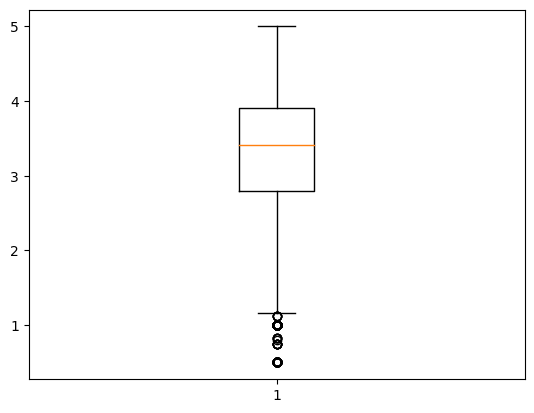

In [50]:
#Commented and updated by shikha
#plt.boxplot(df_merge1['rating'])
plt.boxplot(updated['RatingMean'])

In [22]:
#View of the grouped list
updated

,MovieId,TotalRatings,RatingMean,RatingMedian,RatingStd,Title,Year,Crime,Western,Action,...,Thriller,Adventure,IMAX,Film-Noir,Documentary,Horror,War,Drama,Romance,Sci-Fi
0,1,215,3.920930,4.0,0.834859,Toy Story,1995,No,No,No,...,No,Yes,No,No,No,No,No,No,No,No
1,2,110,3.431818,3.5,0.881713,Jumanji,1995,No,No,No,...,No,Yes,No,No,No,No,No,No,No,No
2,3,52,3.259615,3.0,1.054823,Grumpier Old Men,1995,No,No,No,...,No,No,No,No,No,No,No,No,Yes,No
3,4,7,2.357143,3.0,0.852168,Waiting to Exhale,1995,No,No,No,...,No,No,No,No,No,No,No,Yes,Yes,No
4,5,49,3.071429,3.0,0.907148,Father of the Bride Part II,1995,No,No,No,...,No,No,No,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,193581,1,4.000000,4.0,0.000000,Black Butler: Book of the Atlantic,2017,No,No,Yes,...,No,No,No,No,No,No,No,No,No,No
9720,193583,1,3.500000,3.5,0.000000,No Game No Life: Zero,2017,No,No,No,...,No,No,No,No,No,No,No,No,No,No
9721,193585,1,3.500000,3.5,0.000000,Flint,2017,No,No,No,...,No,No,No,No,No,No,No,Yes,No,No
9722,193587,1,3.500000,3.5,0.000000,Bungo Stray Dogs: Dead Apple,2018,No,No,Yes,...,No,No,No,No,No,No,No,No,No,No


In [23]:
# Data set with all values which we are interested in
updated.head()

,MovieId,TotalRatings,RatingMean,RatingMedian,RatingStd,Title,Year,Crime,Western,Action,...,Thriller,Adventure,IMAX,Film-Noir,Documentary,Horror,War,Drama,Romance,Sci-Fi
0,1,215,3.920930,4.0,0.834859,Toy Story,1995,No,No,No,...,No,Yes,No,No,No,No,No,No,No,No
1,2,110,3.431818,3.5,0.881713,Jumanji,1995,No,No,No,...,No,Yes,No,No,No,No,No,No,No,No
2,3,52,3.259615,3.0,1.054823,Grumpier Old Men,1995,No,No,No,...,No,No,No,No,No,No,No,No,Yes,No
3,4,7,2.357143,3.0,0.852168,Waiting to Exhale,1995,No,No,No,...,No,No,No,No,No,No,No,Yes,Yes,No
4,5,49,3.071429,3.0,0.907148,Father of the Bride Part II,1995,No,No,No,...,No,No,No,No,No,No,No,No,No,No


In [24]:
updated["Year"].unique()

array(['1995', '1994', '1996', '1976', '1992', '1967', '1993', '1964',
       '1977', '1965', '1982', '1990', '1991', '1989', '1937', '1940',
       '1969', '1981', '1973', '1970', '1955', '1959', '1968', '1988',
       '1997', '1972', '1943', '1952', '1951', '1957', '1961', '1958',
       '1954', '1934', '1944', '1960', '1963', '1942', '1941', '1953',
       '1939', '1950', '1946', '1945', '1938', '1947', '1935', '1936',
       '1956', '1949', '1932', '1975', '1974', '1971', '1979', '1987',
       '1986', '1980', '1978', '1985', '1966', '1962', '1983', '1984',
       '1948', '1933', '1931', '1922', '1998', '1929', '1930', '1927',
       '1928', '1999', '2000', '1926', '1919', '1921', '1925', '1923',
       '2001', '2002', '2003', '1920', '1915', '1924', '2004', '1916',
       '1917', '2005', '2006', '1902', '5', '1903', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '1908', 2018, 2015, 2016, 2019, 2017, '2', 2011],
      d

In [25]:
#updated[updated["Year"].apply(lambda x: len(str(x))<4]
updated[updated["Year"].apply(lambda x: len(str(x)) < 4)]

,MovieId,TotalRatings,RatingMean,RatingMedian,RatingStd,Title,Year,Crime,Western,Action,...,Thriller,Adventure,IMAX,Film-Noir,Documentary,Horror,War,Drama,Romance,Sci-Fi
6042,40697,2,2.25,2.25,2.474874,Babylon,5,No,No,No,...,No,No,No,No,No,No,No,No,No,Yes
9507,171891,1,3.50,3.50,0.000000,Generation Iron,2,No,No,No,...,No,No,No,No,No,No,No,No,No,No


In [26]:
#Let's update the columns"no Genres listed" to Unkown
updated.rename(columns={"(no genres listed)":"Unknown"}, inplace=True)
#droping MoviesID as that is not useful for our model nor EDA
ModelData=updated.drop("MovieId",axis=1)

In [27]:
updated.columns

Index(['MovieId', 'TotalRatings', 'RatingMean', 'RatingMedian', 'RatingStd',
       'Title', 'Year', 'Crime', 'Western', 'Action', 'Children', 'Comedy',
       'Mystery', 'Musical', 'Fantasy', 'Animation', 'Unknown', 'Thriller',
       'Adventure', 'IMAX', 'Film-Noir', 'Documentary', 'Horror', 'War',
       'Drama', 'Romance', 'Sci-Fi'],
      dtype='object')

+ The Mean and Median ratings are pretty close showing that the rating on these movies are pretty consitent
+ We can see that there was movies with no ratings

In [28]:
updated.describe()

,MovieId,TotalRatings,RatingMean,RatingMedian,RatingStd
count,9723.000000,9723.000000,9723.000000,9723.000000,9723.000000
mean,42234.224725,10.370770,3.262270,3.291937,0.541749
std,52182.954547,22.401955,0.869740,0.897562,0.509896
min,1.000000,1.000000,0.500000,0.500000,0.000000
25%,3245.000000,1.000000,2.800000,3.000000,0.000000
50%,7299.000000,3.000000,3.416667,3.500000,0.577350
75%,76519.500000,9.000000,3.911239,4.000000,0.928227
max,193609.000000,329.000000,5.000000,5.000000,3.181981


# !!! There are 18 entries movies without ratings we may need to drop these entries therefore we will remove it
***SINCE WE HAVE DONE INNER JOIN ALL MOVIES HAVE RATING NOW***
    

In [29]:
updated[updated["TotalRatings"]==0]["Title"]

Series([], Name: Title, dtype: object)

In [30]:
updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9723 entries, 0 to 9723
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MovieId       9723 non-null   int64  
 1   TotalRatings  9723 non-null   int64  
 2   RatingMean    9723 non-null   float64
 3   RatingMedian  9723 non-null   float64
 4   RatingStd     9723 non-null   float64
 5   Title         9723 non-null   object 
 6   Year          9723 non-null   object 
 7   Crime         9723 non-null   object 
 8   Western       9723 non-null   object 
 9   Action        9723 non-null   object 
 10  Children      9723 non-null   object 
 11  Comedy        9723 non-null   object 
 12  Mystery       9723 non-null   object 
 13  Musical       9723 non-null   object 
 14  Fantasy       9723 non-null   object 
 15  Animation     9723 non-null   object 
 16  Unknown       9723 non-null   object 
 17  Thriller      9723 non-null   object 
 18  Adventure     9723 non-null 

# Data Understanding Part 2
* Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

### Top 10 Rated Movies
Taste for movies are solely subjective, however these top 10 movies all left something very special to watchers that they had to leave a review.

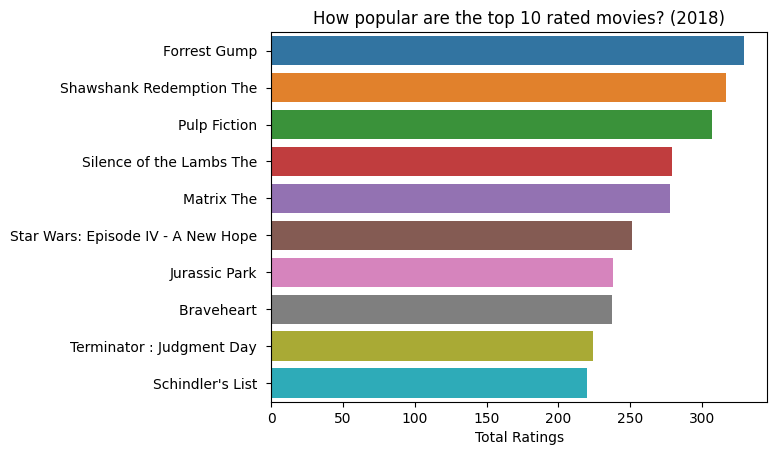

In [85]:
top10movies = updated.nlargest(10, 'TotalRatings')

ax = sns.barplot(x='TotalRatings', y='Title', 
                 data = top10movies)

ax.set(xlabel='Total Ratings',
       ylabel=None,
       title='How popular are the top 10 rated movies? (2018)')

plt.show()

### Distribution of Mean Ratings
The distribution seems left skewed but that does make sense because a majority of movies are created to be enjoyable and often be rated high, as seen with over 2000 ratings are mean rating 4.

Text(0, 0.5, 'Frequency')

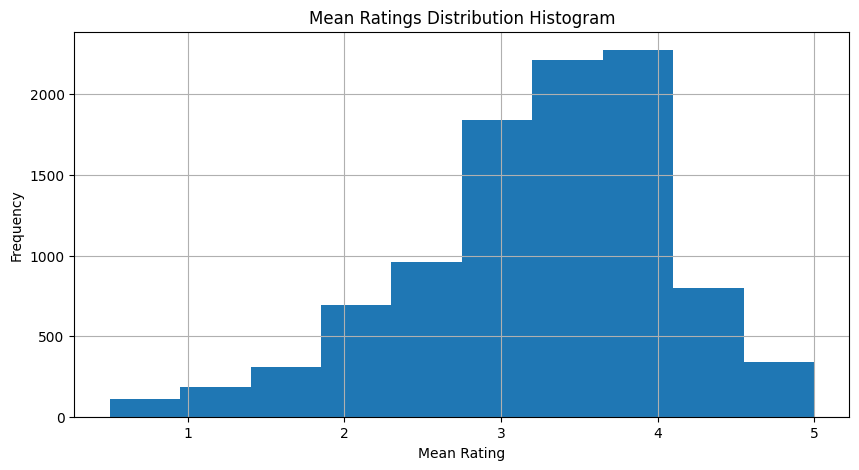

In [81]:
updated.hist('RatingMean', figsize=(10,5))
plt.title("Mean Ratings Distribution Histogram")
plt.xlabel('Mean Rating')
plt.ylabel('Frequency')

### Top 10 Rated Genres
!!! cant figure out this plot since genre is one-hot coded :/

It is not surprising that Comedy genre is a hit with 144 mean 5 star ratings! Movies are an entertainment and comedy movies are a good stressbuster and this data shows that.

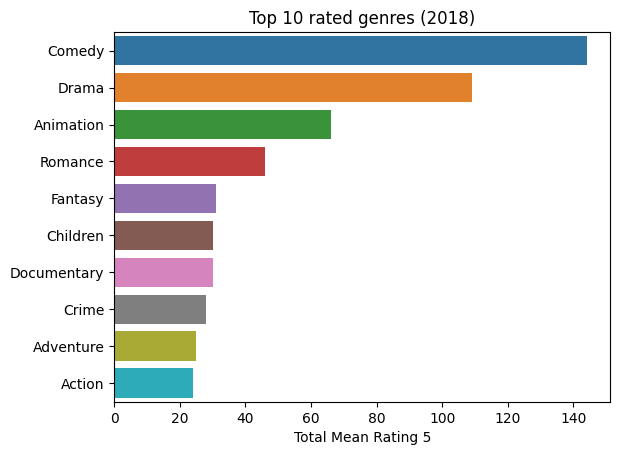

In [119]:
# Create a dataframe for Genres with Mean 5 star Rating counts
topgenres = pd.DataFrame(columns=['Genres','Count'])

for i in genres_list:
    if i == '(no genres listed)':
        i = 'Unknown'
    topgenres = topgenres.append({'Genres': i,
                    'Count': updated[(updated["RatingMean"]==5) & (updated[i]=="Yes")][i].count(),
                   }
                   ,ignore_index=True
                  ).sort_values(by=['Count'], ascending = False)    
#topgenres

ax = sns.barplot(x='Count', y='Genres', data = topgenres.head(10))
ax.set(xlabel='Total Mean Rating 5',
       ylabel=None,
       title='Top 10 rated genres (2018)')

plt.show()

# Modeling and Evaluation
* Different tasks will require different evaluation methods. Be as thorough as possible when analyzing
the data you have chosen and use visualizations of the results to explain the performance and
expected outcomes whenever possible. Guide the reader through your analysis with plenty of
discussion of the results. 

- #### Cluster Analysis 

    - Perform cluster analysis using several clustering methods
    - How did you determine a suitable number of clusters for each method?
    - Use internal and/or external validation measures to describe and compare the clusterings and the clusters (some visual methods would be good).
    - Describe your results. What findings are the most interesting and why? 

# Modeling and Evaluation
* Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?

    - How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
    - How would your deploy your model for interested parties?
    - What other data should be collected?
    - How often would the model need to be updated, etc.? 

#  Exceptional Work
* You have free reign to provide additional analyses or combine analyses